# Forecasting Per-Station Ridership

Next, we turn our attention to forecasting per-station subway ridership. In other words, we will build a model which receives as input past data regarding the ridership of each of the 428 stations, together with temporal data, and will produce a prediction of the ridership of each of the 428 stations in the next hour. To this end, we build two models.
1. Our first model is a multivariate LSTM. This model predicts ridership for eachstation based on past ridership of all other stations.
2. Our second model is a 1-dimensional convolutional neural network (CNN). This model, on the other hand, predicts ridership for each station based on past ridership of only that station.


In [4]:
! wget "drive.google.com/uc?export=download&id=19tT6rV9N0giCBUMcIaBA_MGUJNNFtE2P" -O "MTA_Oct08_sorted_skimmed_station.csv"
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import mapclassify as mc
from shapely.geometry import Point
import os
import imageio
from IPython.display import Image
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import datetime
import copy

device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(device)

URL transformed to HTTPS due to an HSTS policy
--2024-11-23 20:06:54--  https://drive.google.com/uc?export=download&id=19tT6rV9N0giCBUMcIaBA_MGUJNNFtE2P
Resolving drive.google.com (drive.google.com)... 2607:f8b0:4002:c1b::64, 2607:f8b0:4002:c1b::8b, 2607:f8b0:4002:c1b::65, ...
Connecting to drive.google.com (drive.google.com)|2607:f8b0:4002:c1b::64|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=19tT6rV9N0giCBUMcIaBA_MGUJNNFtE2P&export=download [following]
--2024-11-23 20:06:55--  https://drive.usercontent.google.com/download?id=19tT6rV9N0giCBUMcIaBA_MGUJNNFtE2P&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 2607:f8b0:4002:c11::84, 74.125.21.132
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|2607:f8b0:4002:c11::84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36683048 (35M) [application/octet-stream]
Saving 

We start by preparing our data for training, normalizing the ridership of each station.


In [5]:
subwaydata = pd.read_csv('MTA_Oct08_sorted_skimmed_station.csv')

stations = [col for col in subwaydata.columns if "station_" in col] #428 stations!
selected_subway_data = subwaydata[['hourX','hourY','dayOfWeekX','dayOfWeekY','monthX','monthY','isHoliday']+stations].values
unnormalized_selected_subway_data = selected_subway_data.copy()

norm_dict = {}
for idx in range(-len(stations),0):
  mean, std = selected_subway_data[:,idx].mean(), selected_subway_data[:,idx].std()
  norm_dict[subwaydata.columns[idx]] = {"mean": mean, "std": std}

  selected_subway_data[:,idx] = (selected_subway_data[:,idx]-mean)/std

#many-to-many setup
def timeseries_stations_dataset(data,lookback,n_stations=428):#stations come last
    X = []
    y = []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback,:])
        y.append(data[i+lookback,-n_stations:])
    X, y = torch.Tensor(np.array(X)).float(), torch.Tensor(np.array(y)).float()
    return X , y

#cnn model
def cnn_dataset(data,lookback,n_stations=428):
    #INPUT
    # each row in data is [time features, station_ridership]
    #OUTPUT
    #each row in X is conceptually 3D
    #one dimension is the particular station
    #one dimension is the number of features (time features + ridership)
    #one dimension is the lookback
    #However, the 1D CNN takes in the features and lookback per station, so we combine (ravel) the features and lookback dims together
    #so when the CNN slides over each station, it sees a 1D vector of features which time features + ridership for each lookback step (like the Net for total ridership)

    tdata = torch.Tensor(data)
    cnn_data = []
    for i in range(tdata.shape[0]):
        row = tdata[i]
        time_data = row[:-428]
        station_data = row[-428:]
        time_replicated = time_data.repeat(n_stations,1) #since the time features are the same for each station, we make a copy for each station
        block = torch.concat([time_replicated,station_data.unsqueeze(1)],axis=1).T #the station ridership is different (duh), so we concat that onto the time features
        #each block is 2D, where columns are stations and rows are (time features + ridership) for one timestep

        cnn_data.append(block)

    cnn_data = torch.stack(cnn_data) #dim0: hours, dim1: stations, dim2: time features+ridership
    X = []
    y = []
    #now we concatenate the timesteps together to get ((time features+ridership) x lookback) x stations
    for i in range(cnn_data.shape[0] - lookback):
        X.append(cnn_data[i:i+lookback].reshape(lookback*(cnn_data.shape[1]) ,n_stations))
        y.append(cnn_data[i+lookback,-1]) #last row is the station data, not time features

    X, y = torch.Tensor(np.array(X)).float(), torch.Tensor(np.array(y)).float()
    return X , y

class CustomDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self,i):
        return self.X[i], self.y[i]

Next, we define the model classes for the LSTM, dense neural network, linear model, and a 1D CNN.

In [15]:
class LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, output_size, num_stacked_layers,dropout=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first = True,dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self,x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out

class Net(nn.Module):
  def __init__(self,input_size,output_size,hidden_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    #reshape inputs for LSTM compatibility
    x = x.reshape([x.shape[0],-1])
    out = F.relu(self.fc1(x))
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

class LinearModel(nn.Module):
  def __init__(self,input_size,output_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size, output_size)

  def forward(self, x):
    #reshape inputs for LSTM compatibility
    return self.fc1(x.reshape([x.shape[0],-1]))

class CNN1D(torch.nn.Module):
    def __init__(self,input_size,hidden_dim,encoding=None):
        #kernel size 1 means it acts on each station independently
        #in/out channels are number of nodes in Net
        super(CNN1D, self).__init__()
        self.encoding = encoding
        if encoding is not None:
            self.layer1 = torch.nn.Conv1d(in_channels=input_size+encoding.shape[1], out_channels=hidden_dim, kernel_size=1)
        else:
            self.layer1 = torch.nn.Conv1d(in_channels=input_size, out_channels=hidden_dim, kernel_size=1)

        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=1)
        self.act2 = torch.nn.ReLU()
        self.layer3 = torch.nn.Conv1d(in_channels=hidden_dim, out_channels=1, kernel_size=1)
    def forward(self, x):
        if self.encoding is not None:
            if len(x.shape)>2:
                x = torch.cat([x,self.encoding.expand(x.shape[0],-1,-1)],axis=1)
            else:
                x = torch.cat([x,self.encoding.squeeze(0)],axis=0)
        x = self.layer1(x)
        x = self.act1(x)
        x = self.layer2(x)
        x = self.act2(x)
        x = self.layer3(x)
        return x.squeeze(1)

Then we define functions for training a given model

In [16]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader,val_loader=None,tag=""):
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,[i*(n_epochs//3) for i in range(1,3)],gamma=0.2) #drop LR 3 times
    model.train()
    trainLosses = []
    valLosses = []
    minValLoss = None
    bestModel = None
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        loss_val = 0.0

        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_train += loss.item()
        if epoch ==1 or epoch % 10 == 0:
            if val_loader:
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        outputs = model(inputs)
                        loss_val+=loss_fn(outputs, labels).item()
                print('{} Epoch {}, Training loss {:.4f}, Validation loss {:.4f}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader),loss_val/len(val_loader)))
                trainLosses.append((loss_train/len(train_loader)))
                valLosses.append((loss_val/len(val_loader)))

                if minValLoss==None or minValLoss>loss_val/len(val_loader):
                    minValLoss = loss_val/len(val_loader)
                    bestModel = copy.deepcopy(model).to(device)
            else:
                pass
    if bestModel:
        model = bestModel
    model.eval()
    plt.plot(trainLosses,label="training loss")
    plt.plot(valLosses,label="validation loss")
    plt.xlabel("10's of epochs")
    plt.yscale('log')
    plt.ylabel("loss")
    plt.legend()
    plt.savefig("loss_e{}_lr{}_b{}_{}.png".format(n_epochs,optimizer.param_groups[-1]['lr'],train_loader.batch_size,tag))
    plt.show()
    plt.clf()

def TrainOnMultistationDataset(dataset,model,mode,lookback,epochs,batch_size=32,learning_rate=.001,tag=""): #selected_subway_weather_data,12
  if mode=="CNN":
    print("CNN mode")
    X , y  = cnn_dataset(dataset,lookback,n_stations=len(stations))
  elif mode=="default":
    X , y  = timeseries_stations_dataset(dataset,lookback,n_stations=len(stations))
  X=X.to(device)
  y=y.to(device)
  input_shape = X.shape[2]

  split_val_index = int(len(X)*0.7)
  split_test_index = int(len(X)*0.8)

  X_train = X[:split_val_index]
  X_val = X[split_val_index:split_test_index]
  X_test = X[split_test_index:]

  y_train = y[:split_val_index]
  y_val = y[split_val_index:split_test_index]
  y_test = y[split_test_index:]

  data_train = CustomDataset(X_train,y_train)
  data_val = CustomDataset(X_val,y_val)
  data_test = CustomDataset(X_test,y_test)

  train_loader = DataLoader(data_train, batch_size = batch_size, shuffle = True)
  val_loader = DataLoader(data_val, batch_size = batch_size, shuffle = True)
  test_loader = DataLoader(data_test, batch_size = batch_size, shuffle = True)
    
  learning_rate = learning_rate
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

  training_loop(
      n_epochs = epochs,
      optimizer = optimizer,
      model = model,
      loss_fn = loss_fn,
      train_loader = train_loader,
      val_loader = val_loader,
      tag = tag

  )
  return model,X_test,y_test

Lastly, we have functions to compute and visualize model performance.

In [8]:
def computeExtrapolation(model,X,y,lookback,n_start,n_future):
  with torch.no_grad():
      iterative_preds = torch.zeros((n_future,lookback,y.shape[1])).to(device)
      iterative_preds[0]=X[n_start,:,0:1].detach().clone()

      fixed_features = X[n_start:n_start+n_future,:,:-y.shape[1]]#get fixed features (time,weather,etc) assuming station ridership comes last
      for k in range(n_future-1):
        nextInput = torch.concat([fixed_features[k],iterative_preds[k]],dim=1).unsqueeze(0)
        prediction = model( nextInput)
        iterative_preds[k+1]=torch.concat([iterative_preds[k][1:],prediction])
      return iterative_preds[1:,-1].detach(),y[n_start:n_start+n_future-1].detach()

def computeExtrapolationCNN(model,X,y,lookback,n_start,n_future):
    with torch.no_grad():
        iterative_preds = torch.zeros((n_future,lookback,y.shape[1])).to(device)
        iterative_preds[0] = X[n_start].reshape(12,8,428)[:,-1].detach().clone()

        #Here, we need to separate the time features from the station ridership
        #So, we reshape the 1D features back into the 2D array of (lookback x time features)
        #then the time features are everything except the last column, and the ridership is the last column
        #We replace the true station ridership with the predictions and concatenate it with the time features
        #Then we reshape the 2D (lookback x time features) back to 1D to work with the 1D CNN

        for k in range(n_future-1):
            time_features = X[n_start+k].reshape(12,8,428)[:,:-1,:]
            preds = iterative_preds[k].reshape(12,1,428)

            nextInput = torch.concat([time_features,preds],axis=1).reshape(-1,428)
            prediction = model( nextInput)

            iterative_preds[k+1]=torch.concat([iterative_preds[k,1:],prediction])

        return iterative_preds[1:,-1,:].detach(),y[n_start:n_start+n_future-1].detach()

def forecast(model,X_test,y_test,lookback,n_future,CNN=False):
    #for each point, do iterative forecast. Store the error for X hours ahead and return vec of MSE
    squaredErrorsPerStation = torch.zeros(n_future-1,y_test.shape[1]).to(device)
    for i in range(X_test.shape[0]-n_future):
        if CNN:
            extrapolated_pred, extrapolated_truth = computeExtrapolationCNN(model,X_test,y_test,lookback,i,n_future)
        else:
            extrapolated_pred, extrapolated_truth = computeExtrapolation(model,X_test,y_test,lookback,i,n_future)
        squaredErrorsPerStation += (extrapolated_truth-extrapolated_pred)**2
    return squaredErrorsPerStation/(X_test.shape[0]-n_future)

def forecastCNN(model,X_test,y_test,lookback,n_future):
    squaredErrorsPerStation = torch.zeros(n_future-1,y_test.shape[1]).to(device)
    for i in range(X_test.shape[0]-n_future):
        extrapolated_pred, extrapolated_truth = computeExtrapolationCNN(model,X_test,y_test,lookback,i,n_future)
        squaredErrorsPerStation += (extrapolated_truth-extrapolated_pred)**2
    return squaredErrorsPerStation/(X_test.shape[0]-n_future)
    
def summaryPlot(forecastMSEs,tag=""):
  print(forecastMSEs.shape)
  print("Tot RMSE error: {:.5f}".format(forecastMSEs.sum().sqrt()))
  fig = plt.figure(figsize=(12,8))
  fig.suptitle("total error {:.3f}".format(forecastMSEs.sum().sqrt()))
  gs = fig.add_gridspec(2,2)
  ax1 = fig.add_subplot(gs[0:-1, :-1])
  ax2 = fig.add_subplot(gs[0:-1, -1])
  ax3 = fig.add_subplot(gs[-1, :])
  #rows:hours, cols:stations

  #plot RMSE integrated over stations
  ax1.scatter(range(forecastMSEs.shape[0]),forecastMSEs.sum(axis=1).sqrt())
  ax1.set_title("RMSE by hour")
  ax1.set_xlabel("hour")
  ax1.set_ylabel("RMSE")

  #RMSE integrated over hours (showing each station)
  ax2.hist(forecastMSEs.sum(axis=0).sqrt(),histtype='step',bottom=0,bins=50)
  ax2.set_title("RMSE by station")
  ax2.set_xlabel("RMSE")
  ax2.set_ylabel("stations")

  #2D RMSE per hour and station
  im = ax3.imshow(forecastMSEs.sqrt(),aspect='auto',cmap='coolwarm',origin='lower',interpolation="none")
  cbar = plt.colorbar(im,pad=.01,fraction=.02)
  cbar.set_label("RMSE")
  ax3.set_xlabel("station")
  ax3.set_ylabel("hour")

  plt.savefig("RMSE_summary_{}.png".format(tag))
  plt.show()
  plt.clf()

def stationPlots(preds,truth,tag=""):
  print("start")
  plt.plot(preds.numpy())
  plt.savefig("all_predictions_{}.png".format(tag))
  plt.show()
  plt.clf()
  print("loop")
  for i in range(len(stations)):
      plt.plot(truth[:,i],label='truth')
      plt.plot(preds[:,i],label='pred',linestyle='dashed')
      plt.title(stations[i])
      plt.xlabel("time")
      plt.ylabel("ridership (normalized)")
      plt.savefig("station_plots/"+stations[i]+".png")
      plt.clf()
  print("Look in station_plots for the individual station predictions")

## Many-to-many Models
As a first attempt, we train models that recieve and predict all 428 stations simultaneously. This is a direct extension of the total ridership models, scaling from univariate to multivariate models. We train:
 - LSTM
 - Dense Neural Network
 - Linear Model

First, the LSTM

2024-11-18 10:48:56.958720 Epoch 1, Training loss 0.0682, Validation loss 0.0643
2024-11-18 10:50:36.885126 Epoch 10, Training loss 0.0274, Validation loss 0.0424
2024-11-18 10:52:29.498644 Epoch 20, Training loss 0.0228, Validation loss 0.0398
2024-11-18 10:54:22.015174 Epoch 30, Training loss 0.0202, Validation loss 0.0392
2024-11-18 10:56:14.672367 Epoch 40, Training loss 0.0180, Validation loss 0.0388
2024-11-18 10:58:07.228117 Epoch 50, Training loss 0.0164, Validation loss 0.0391
2024-11-18 10:59:59.815324 Epoch 60, Training loss 0.0151, Validation loss 0.0395
2024-11-18 11:01:52.373680 Epoch 70, Training loss 0.0139, Validation loss 0.0400
2024-11-18 11:03:44.705461 Epoch 80, Training loss 0.0129, Validation loss 0.0407
2024-11-18 11:05:37.339126 Epoch 90, Training loss 0.0120, Validation loss 0.0411
2024-11-18 11:07:30.019671 Epoch 100, Training loss 0.0112, Validation loss 0.0419
2024-11-18 11:09:22.642041 Epoch 110, Training loss 0.0104, Validation loss 0.0427
2024-11-18 11:1

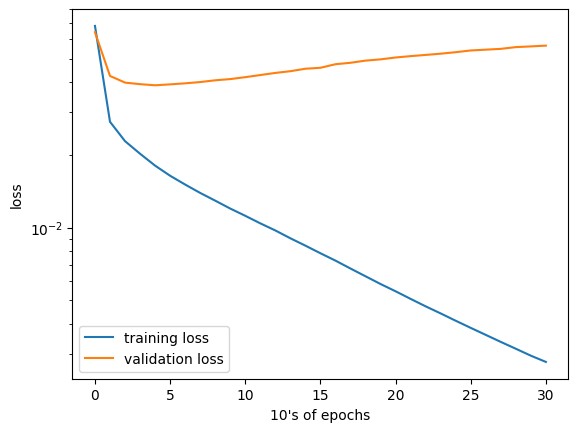

torch.Size([11, 428])
Tot RMSE error: 92.21115


<Figure size 640x480 with 0 Axes>

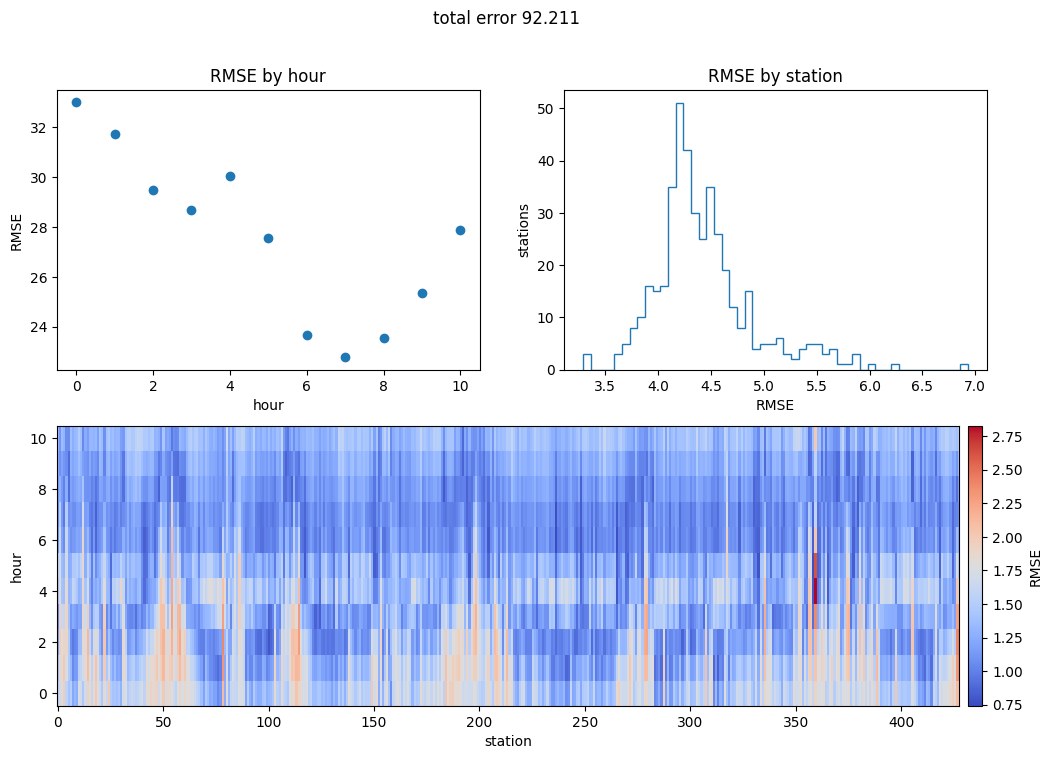

<Figure size 640x480 with 0 Axes>

In [5]:
forecastLimit = 12 #hours
epochs = 300
batch_size=32
learning_rate=.001
lookback = 12
tag="MultistationLSTM"
input_shape = selected_subway_data.shape[1]

model_LSTM = LSTM(input_shape,2048,len(stations),1).to(device)

model_LSTM,X_test_subway,y_test_subway = TrainOnMultistationDataset(selected_subway_data,model_LSTM,"default",lookback,epochs,batch_size,learning_rate,tag)
forecastMSEs=forecast(model_LSTM,X_test_subway,y_test_subway,lookback,forecastLimit)
summaryPlot(forecastMSEs.cpu(),tag)

torch.save(model_LSTM,"models/LSTM_multistation.pt")

To evaluate the LSTM and other models, we'll compute the root mean square error for each station extrapolated a number of hours in advance. Then we can plot the total RMSE each hour into the future (upper left), the distribution of station 0-hour RMSEs (upper right), and the RMSE for each station and hour (lower).

In [ ]:
preds, truth = computeExtrapolation(model_LSTM,X_test_subway,y_test_subway,lookback=lookback,n_start=0,n_future=24*5)

Now we do the same for the dense neural network

2024-11-18 12:22:38.064445 Epoch 1, Training loss 0.0937, Validation loss 0.0924
2024-11-18 12:22:49.992653 Epoch 10, Training loss 0.0390, Validation loss 0.0544
2024-11-18 12:23:02.922483 Epoch 20, Training loss 0.0316, Validation loss 0.0485
2024-11-18 12:23:15.550013 Epoch 30, Training loss 0.0279, Validation loss 0.0448
2024-11-18 12:23:28.094711 Epoch 40, Training loss 0.0256, Validation loss 0.0433
2024-11-18 12:23:40.619099 Epoch 50, Training loss 0.0238, Validation loss 0.0423
2024-11-18 12:23:53.176619 Epoch 60, Training loss 0.0223, Validation loss 0.0428
2024-11-18 12:24:05.705582 Epoch 70, Training loss 0.0211, Validation loss 0.0406
2024-11-18 12:24:18.297742 Epoch 80, Training loss 0.0202, Validation loss 0.0404
2024-11-18 12:24:30.861440 Epoch 90, Training loss 0.0193, Validation loss 0.0399
2024-11-18 12:24:43.392589 Epoch 100, Training loss 0.0186, Validation loss 0.0401


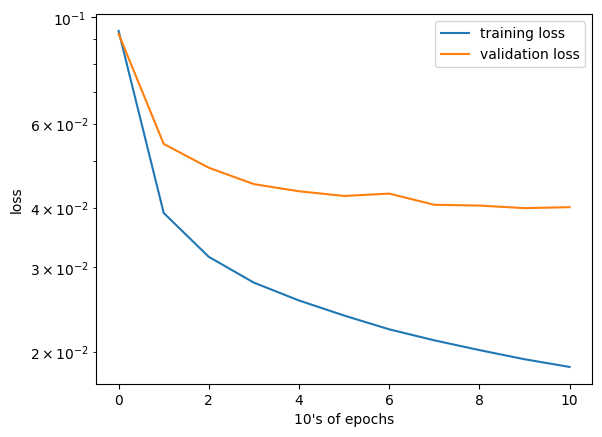

torch.Size([11, 428])
Tot RMSE error: 71.93954


<Figure size 640x480 with 0 Axes>

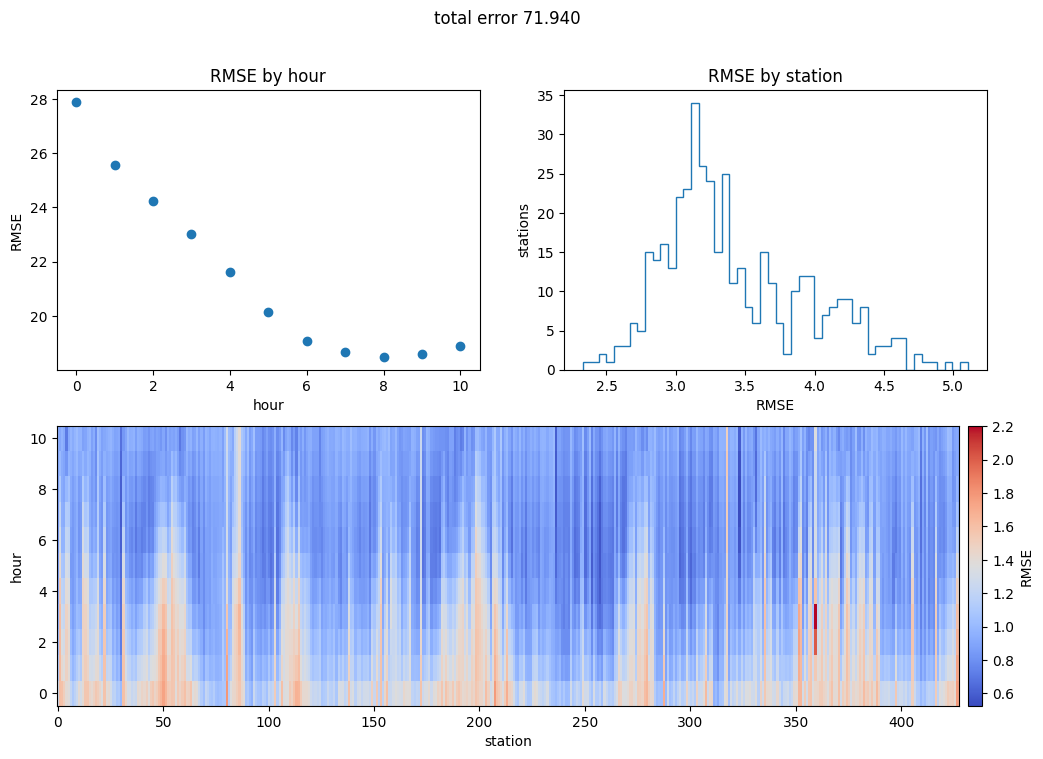

<Figure size 640x480 with 0 Axes>

In [13]:
forecastLimit = 12 #hours
epochs = 100
batch_size=32
learning_rate=.001
lookback = 12
tag="MultistationNN"
input_shape = selected_subway_data.shape[1]

model_NN = Net(input_shape*lookback,len(stations),len(stations)*2).to(device)

model_NN,X_test_subway,y_test_subway = TrainOnMultistationDataset(selected_subway_data,model_NN,"default",lookback,epochs,batch_size,learning_rate,tag)
forecastMSEs=forecast(model_NN,X_test_subway,y_test_subway,lookback,forecastLimit)
summaryPlot(forecastMSEs.cpu(),tag)

preds, truth = computeExtrapolation(model_NN,X_test_subway,y_test_subway,lookback=lookback,n_start=0,n_future=24*5)
torch.save(model_NN,"models/NN_multistation.pt")

And finally the linear model.

2024-11-18 12:24:55.249633 Epoch 1, Training loss 0.1583, Validation loss 0.1140
2024-11-18 12:25:01.307822 Epoch 10, Training loss 0.0442, Validation loss 0.0609
2024-11-18 12:25:07.981997 Epoch 20, Training loss 0.0359, Validation loss 0.0530
2024-11-18 12:25:14.828121 Epoch 30, Training loss 0.0323, Validation loss 0.0493
2024-11-18 12:25:21.675167 Epoch 40, Training loss 0.0301, Validation loss 0.0470
2024-11-18 12:25:28.468427 Epoch 50, Training loss 0.0286, Validation loss 0.0467
2024-11-18 12:25:35.198739 Epoch 60, Training loss 0.0274, Validation loss 0.0459
2024-11-18 12:25:41.939430 Epoch 70, Training loss 0.0266, Validation loss 0.0459
2024-11-18 12:25:48.661298 Epoch 80, Training loss 0.0258, Validation loss 0.0453
2024-11-18 12:25:55.336322 Epoch 90, Training loss 0.0253, Validation loss 0.0447
2024-11-18 12:26:02.089323 Epoch 100, Training loss 0.0248, Validation loss 0.0447


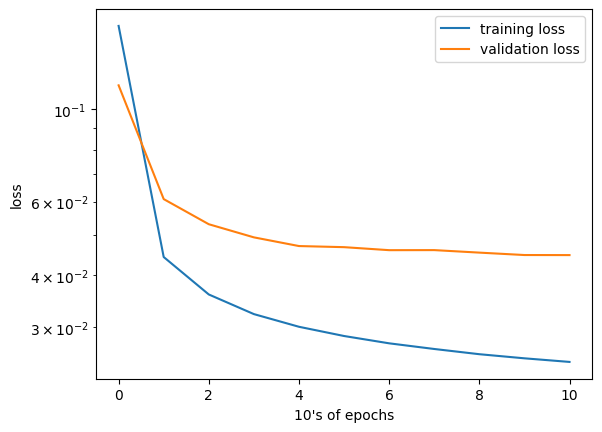

torch.Size([11, 428])
Tot RMSE error: 69.41563


<Figure size 640x480 with 0 Axes>

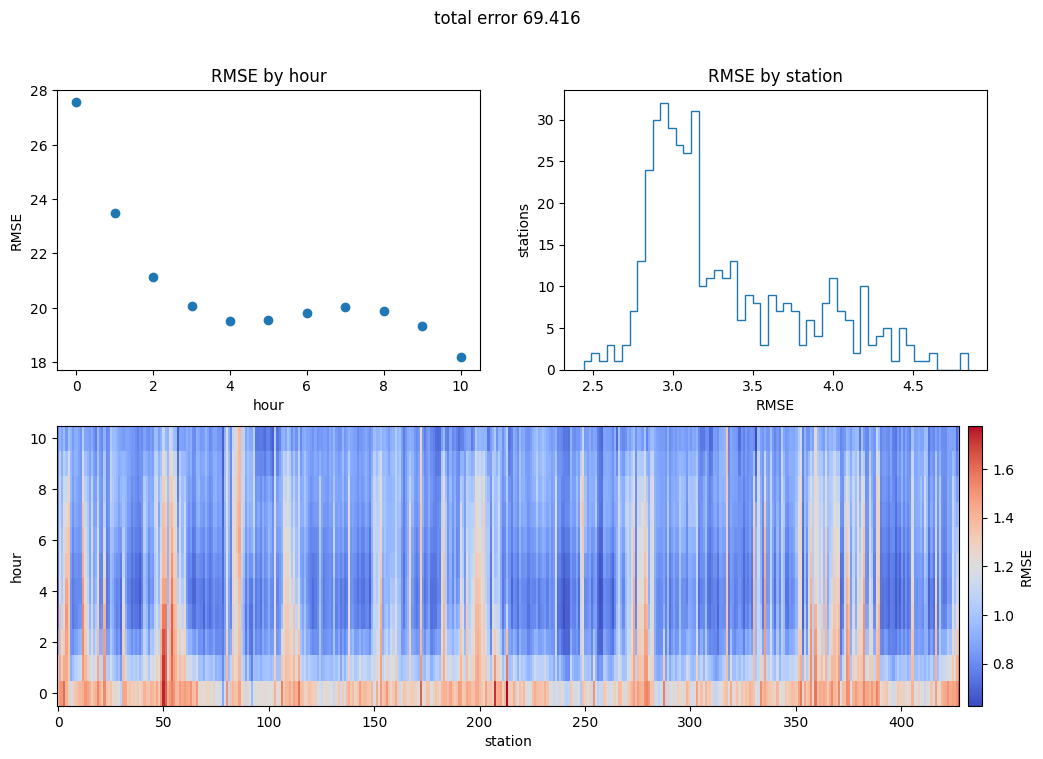

<Figure size 640x480 with 0 Axes>

In [14]:
forecastLimit = 12 #hours
epochs = 100
batch_size=32
learning_rate=.001
lookback = 12
tag="MultistationLinear"
input_shape = selected_subway_data.shape[1]

model_linear = LinearModel(input_shape*lookback,len(stations)).to(device)

model_linear,X_test_subway,y_test_subway = TrainOnMultistationDataset(selected_subway_data,model_linear,"default",lookback,epochs,batch_size,learning_rate,tag)
forecastMSEs=forecast(model_linear,X_test_subway,y_test_subway,lookback,forecastLimit)
summaryPlot(forecastMSEs.cpu(),tag)

preds, truth = computeExtrapolation(model_linear,X_test_subway,y_test_subway,lookback=lookback,n_start=0,n_future=24*5)
torch.save(model_LSTM,"models/Linear_Multistation.pt")

The many-to-many approach struggles to get a reasonable RMSE. As even the linear model displays overfitting, the limitation seems to arise from the dataset. With about 20k hourly datapoints and correlated behavior between stations, the models put too much weight on stations beyond the one predicted. This was confirmed by training "many-to-many" models on a subset of stations, which performed substantially better.

## 1D CNN
To overcome the limitation, we created a model akin to the Total Ridership dense neural network that recieves the time series for a single station and the standard time features. Implementing it as a 1D CNN with input features as channels allows it to be evaluated on each station in a single pass. Stations are encoded as random 16-dimensional vectors with elements between 0 and 1.

CNN mode
2024-11-23 20:07:09.300159 Epoch 1, Training loss 0.9005, Validation loss 0.1542
2024-11-23 20:07:15.417950 Epoch 10, Training loss 0.0903, Validation loss 0.0913
2024-11-23 20:07:22.159356 Epoch 20, Training loss 0.0726, Validation loss 0.0773
2024-11-23 20:07:28.859953 Epoch 30, Training loss 0.0667, Validation loss 0.0672
2024-11-23 20:07:35.562124 Epoch 40, Training loss 0.0621, Validation loss 0.0642
2024-11-23 20:07:42.259615 Epoch 50, Training loss 0.0602, Validation loss 0.0636
2024-11-23 20:07:49.001888 Epoch 60, Training loss 0.0589, Validation loss 0.0627
2024-11-23 20:07:55.705663 Epoch 70, Training loss 0.0583, Validation loss 0.0618
2024-11-23 20:08:02.441802 Epoch 80, Training loss 0.0574, Validation loss 0.0605
2024-11-23 20:08:09.176999 Epoch 90, Training loss 0.0573, Validation loss 0.0623
2024-11-23 20:08:15.961183 Epoch 100, Training loss 0.0564, Validation loss 0.0591
2024-11-23 20:08:22.707591 Epoch 110, Training loss 0.0559, Validation loss 0.0605
2024-1

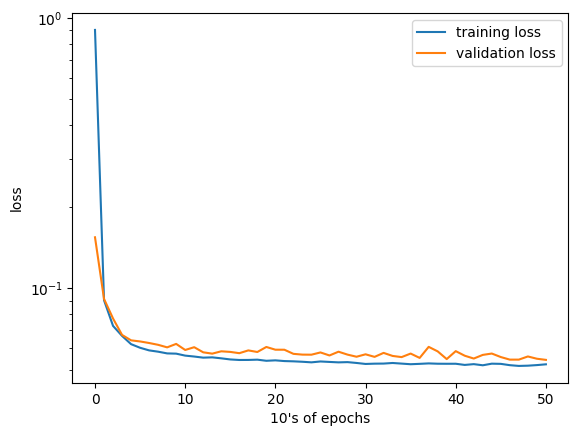

torch.Size([11, 428])
Tot RMSE error: 28.90637


<Figure size 640x480 with 0 Axes>

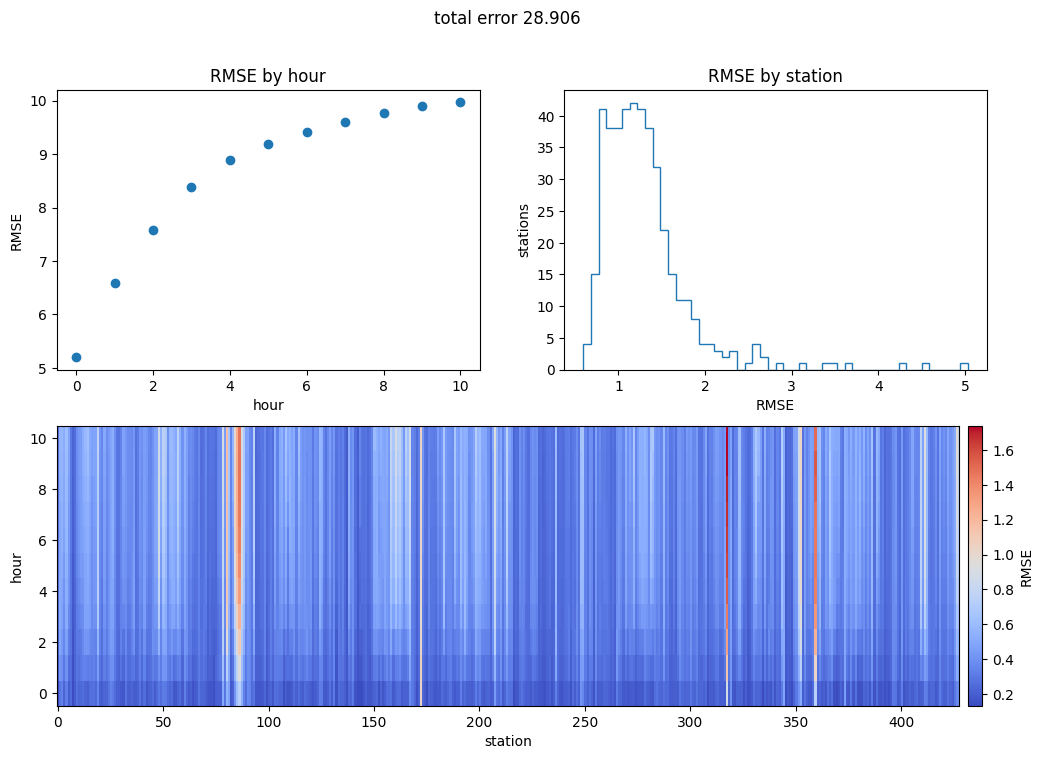

<Figure size 640x480 with 0 Axes>

In [9]:
forecastLimit = 12 #hours
RMSEs = []
trials = 1
epochs = 500 #suggested 500 for training
batch_size=32
learning_rate=.1
lookback = 12

encode_dim = 16
input_shape = lookback*(1+selected_subway_data.shape[1]-len(stations))
encoding = torch.rand((1,encode_dim,len(stations))).to(device)

model_cnn = CNN1D(input_shape,(input_shape+encode_dim)//2,encoding=encoding).to(device)
model_cnn_subway,X_test_subway,y_test_subway = TrainOnMultistationDataset(selected_subway_data,model_cnn,"CNN",lookback,batch_size=batch_size,epochs=epochs,learning_rate=learning_rate,tag="CNN")

torch.save(model_cnn_subway,"models/cnn_multistation.pt")

# load 500 epoch trained model
if epochs==0:
    model_cnn_subway = torch.load("models/cnn_multistation.pt",weights_only=False,map_location=torch.device(device))

forecastMSEs=forecastCNN(model_cnn_subway,X_test_subway,y_test_subway,lookback,forecastLimit)
summaryPlot(forecastMSEs.cpu(),"CNN")

preds, truth = computeExtrapolationCNN(model_cnn_subway,X_test_subway,y_test_subway,lookback=lookback,n_start=0,n_future=24*5)

Next we can visualize the predictions for all stations

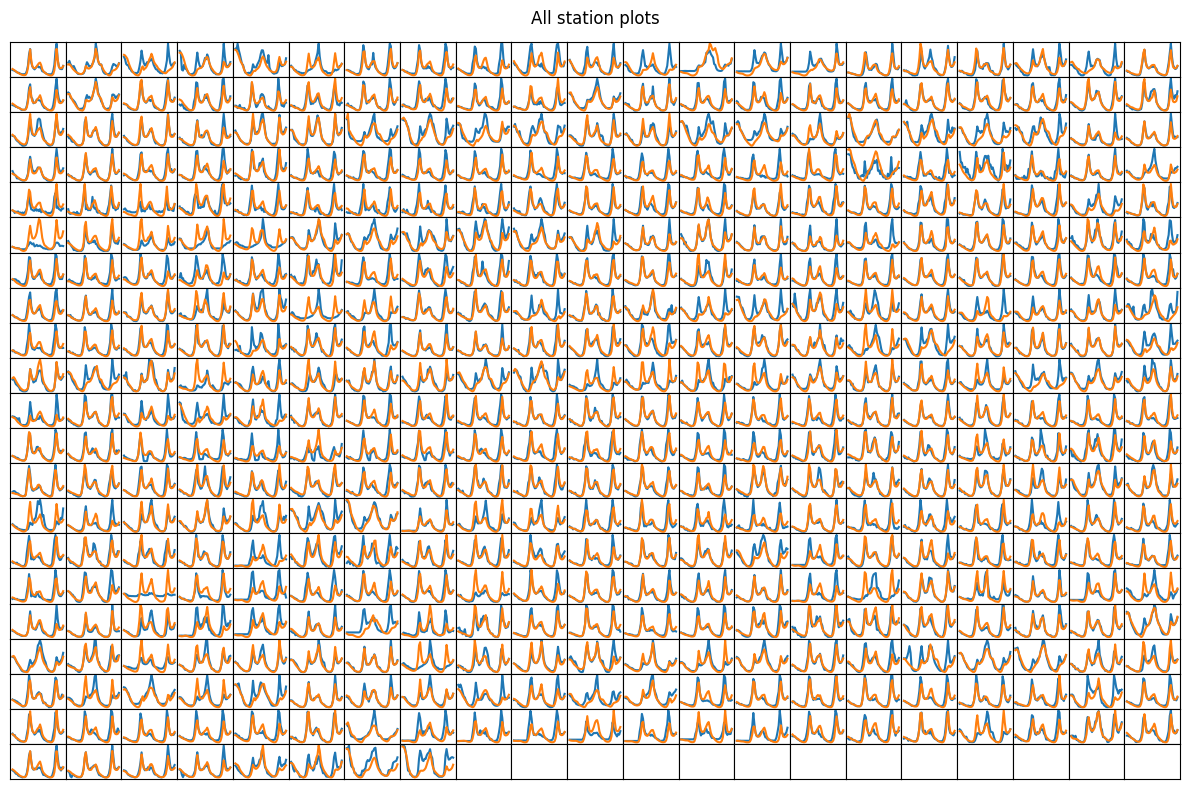

In [7]:
preds, truth = computeExtrapolationCNN(model_cnn_subway,X_test_subway,y_test_subway,lookback=lookback,n_start=100,n_future=48)

truthvals = truth.cpu()
vals = preds.cpu()
fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(21,21, hspace=0)
gs.update(wspace=0, hspace=0)
axs = gs.subplots()
fig.suptitle('All station plots')
plt.subplots_adjust(wspace=0, hspace=0)

for i,ax in enumerate(axs.ravel()):
    if i<vals.shape[1]:
        ax.plot(truthvals[:,i])
        ax.plot(vals[:,i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)# Hide x labels and tick labels for all but bottom plot.

plt.tight_layout()
plt.show()

# Map Visualization

Load station coordinates from file

In [12]:
sourcedata = pd.read_csv("stationLocations.csv")

In [13]:
#time and data formatting
from_military_time = {}
from_military_time[0] = '12:00:00 AM'
from_military_time[12] = '12:00:00 PM'

for t in range(1,12):
  from_military_time[t] = str(t).zfill(2) + ':00:00 AM'
  from_military_time[t+12] = str(t).zfill(2) + ':00:00 PM'

dictionary = {}
for i, row in sourcedata.iterrows():
  if row['station_complex_id'] not in dictionary.keys():
    dictionary[row['station_complex_id']] = [0]*24

for i, row in sourcedata.iterrows():
  dictionary[row['station_complex_id']][int(row['transit_timestamp'].split("T")[1].split(":")[0]) -1] += row['ridership']

data = sourcedata[['station_complex_id','longitude','latitude']].copy()
data.drop_duplicates(subset= 'station_complex_id', keep = 'first', inplace = True, ignore_index = True)
for t in range(24):
  data[from_military_time[t] + ' ridership'] = 0

for station in dictionary.keys():
  for t in range(24):
    data.loc[data['station_complex_id'] == station, from_military_time[t] + ' ridership'] = dictionary[station][t]
for t in range(24):
  data[from_military_time[t] + ' ridershipscaled'] = 2*np.sqrt(1 + data[from_military_time[t] + ' ridership'] )


In [14]:
#preds, truth need to start at midnight: test dataset start at 14 + 24*n
# subwaydata.iloc[int(len(subwaydata)*0.8)+14]['timestamp']
preds, truth = computeExtrapolationCNN(model_cnn_subway,X_test_subway,y_test_subway,lookback=lookback,n_start=14,n_future=24*4+1)

new_order = [0]*428
for i in range(428):
  for j in range(428):
    if 'station_'+data.iloc[j]['station_complex_id'] == stations[i]:
      new_order[i] = j
      break

reordered_data = data.reindex(new_order)
reordered_data = reordered_data[['station_complex_id','longitude','latitude']].copy()
reordered_data.index = range(len(reordered_data))

unnormalized_preds = preds.cpu().numpy().copy()
unnormalized_truth = truth.cpu().numpy().copy()

for s in range(len(stations)):
    mean,std = norm_dict[stations[s]]["mean"], norm_dict[stations[s]]["std"]
    unnormalized_preds[:,s] = unnormalized_preds[:,s]*std+mean
    unnormalized_truth[:,s] = unnormalized_truth[:,s]*std+mean

new_pred_columns = {'Day '+str(d) + ' ' + from_military_time[t] + ' predicted ridership': unnormalized_preds[24*d + t] for d in range(4) for t in range(24)}
new_truth_columns = {'Day '+str(d) + ' ' + from_military_time[t] + ' true ridership': unnormalized_truth[24*d + t] for d in range(4) for t in range(24)}

reordered_data = pd.concat([reordered_data,pd.DataFrame(new_pred_columns)],axis=1)
reordered_data = pd.concat([reordered_data,pd.DataFrame(new_truth_columns)],axis=1)

new_scaled_pred_columns = {'Day '+str(d) + ' ' + from_military_time[t] + ' scaled predicted ridership': 2*np.sqrt(np.abs(unnormalized_preds[24*d + t])+1) for d in range(4) for t in range(24)}
new_scaled_truth_columns = {'Day '+str(d) + ' ' + from_military_time[t] + ' scaled true ridership': 2*np.sqrt(np.abs(unnormalized_truth[24*d + t])+1) for d in range(4) for t in range(24)}

reordered_data = pd.concat([reordered_data,pd.DataFrame(new_scaled_pred_columns)],axis=1)
reordered_data = pd.concat([reordered_data,pd.DataFrame(new_scaled_truth_columns)],axis=1)


Next, we can plot the true values of the ridership in our four day window.

In [ ]:
! mkdir -p mergedsubwayimages
for d in range(4):
  for t in range(24):
    df_geo_pred = gpd.GeoDataFrame(
      reordered_data, geometry=gpd.points_from_xy(reordered_data.longitude, reordered_data.latitude))
    fig, axes = plt.subplots(figsize=(20,10),ncols=2)
    fig.suptitle('MTA ridership on day ' + str(d) +' at ' + from_military_time[t][:5]+from_military_time[t][-3:],fontsize=36)
    boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))
    axis = boroughs.plot(color = 'lightgray', edgecolor = 'black',ax=axes[0])
    axis.set_ylim(40.52,40.94)
    axis.set_xlim((-74.1, -73.72)) 
    axis.set_title('Predicted', fontsize = 30)

    bins = [20,40,80,160,320,640,1280, 2560, 5120, 10240, 20480]
    df_geo_pred.plot( 'Day '+str(d) + ' ' + from_military_time[t]+' predicted ridership',
              markersize = 'Day '+str(d) + ' ' + from_military_time[t] + ' scaled predicted ridership',
               scheme = 'userdefined',
               legend = False, k = 10,
               ax = axis, cmap = 'plasma',
               
               classification_kwds={'bins': bins, 'lowest':0})
    axis = boroughs.plot(color = 'lightgray', edgecolor = 'black',ax=axes[1])
    axis.set_ylim(40.52,40.94)
    axis.set_xlim((-74.1, -73.72))
      
    df_geo_pred.plot( 'Day '+str(d) + ' ' + from_military_time[t]+' true ridership',
              markersize = 'Day '+str(d) + ' ' + from_military_time[t] + ' scaled true ridership',
               scheme = 'userdefined',
               legend = True, k = 10,
               ax = axis, cmap = 'plasma',
               legend_kwds = {'title': 'Ridership',
                              'title_fontsize':30,
                              'loc' : 'center right',
                              'bbox_to_anchor' : (1.75,0.5),
                              'fontsize' : 30,
                              'fancybox' : True,
                              'labels':['0 - 20', '20 - 40', '40 - 80', '80 - 160', '160 - 320', '320 - 640', '640 - 1280', '1280 - 2560', '2560 - 5120', '5120 - 10240', '10240 - 20480']},
               classification_kwds={'bins': bins, 'lowest':0})
    axis.set_title('True', fontsize = 30)
    fig.tight_layout()
    plt.savefig(f'mergedsubwayimages/{d}{t:002}', bbox_inches = 'tight')
    plt.close()

images = []
images_path = 'mergedsubwayimages'

for filename in sorted(os.listdir(images_path)):
  if filename.endswith('.png'):
    images.append(imageio.imread(os.path.join(images_path,filename)))

imageio.mimsave('plots/mergedMTAanimation.gif', images, fps = 3, loop = 0)
Image("plots/mergedMTAanimation.gif")